In [1]:
# 1. Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('pre_DOGE-USD.csv')
df1 = df['Close'].values.reshape(-1, 1)

In [3]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(df1)

In [4]:
# 4. Chia dữ liệu 9 - 1
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (2056, 1)
Test shape: (229, 1)


In [5]:
# 5. Create dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
# 6. Chuẩn bị dữ liệu
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
combined_data = np.concatenate((train_data[-time_step:], test_data))
x_test, y_test = create_dataset(combined_data, time_step)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test", y_test.shape)

x_train:  (1955, 100)
y_train:  (1955,)
x_test:  (228, 100)
y_test (228,)


In [7]:
# 7. Huấn luyện mô hình Linear Regression cho trend
linear_reg = LinearRegression()
linear_reg.fit(x_train, y_train)

LinearRegression()

In [8]:
# 8. Dự đoán trend cho train và test data
trend_train = linear_reg.predict(x_train)
trend_test = linear_reg.predict(x_test)

In [9]:
# 9. Loại bỏ trend khỏi dữ liệu gốc
residual_train = y_train - trend_train
residual_test = y_test - trend_test

In [10]:
# 10. Huấn luyện mô hình Exponential Smoothing cho seasonal component
seasonal_model = ExponentialSmoothing(residual_train, seasonal='add', seasonal_periods=12)
seasonal_fit = seasonal_model.fit()

In [11]:
# 11. Loại bỏ seasonal component khỏi residual
detrended_residual_train = residual_train - seasonal_fit.fittedvalues
detrended_residual_test = residual_test - seasonal_fit.forecast(len(residual_test))

In [12]:
# 12. Huấn luyện mô hình XGBoost cho detrended residual
xgb = XGBRegressor()
xgb.fit(x_train, detrended_residual_train)

[17:03:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [13]:
# 13. Dự đoán detrended residual cho train và test data
residual_train_pred = xgb.predict(x_train)
residual_test_pred = xgb.predict(x_test)

In [14]:
# 14. Kết hợp dự đoán
y_train_pred = trend_train + seasonal_fit.fittedvalues + residual_train_pred
y_test_pred = trend_test + seasonal_fit.forecast(len(residual_test)) + residual_test_pred

In [15]:
# 15. Tính RMSE, MAPE, MAE
test_rmse = np.sqrt(np.mean((y_test_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_test - y_test_pred))
print('Testing MAE:', test_mae)

Testing RMSE: 0.012309942575476927
Testing MAPE: 4.643777048954631
Testing MAE: 0.008485925915402074


In [16]:
# 16. Hàm dự báo cho 30, 60, 90 ngày tiếp theo
def forecast_days(n_days):
    n_steps = 100
    last_100_days = df1[-n_steps:].reshape(1, -1)

    predicted_values = []

    for i in range(n_days):
        trend_next = linear_reg.predict(last_100_days)
        seasonal_next = seasonal_fit.forecast(1)
        residual_next = xgb.predict(last_100_days)
        predicted_next = trend_next + seasonal_next + residual_next
        predicted_values.append(predicted_next)
        last_100_days = np.append(last_100_days[:,1:], predicted_next).reshape(1,-1)

    return np.array(predicted_values)

In [17]:
# 17. Dự báo 30, 60, 90 ngày
forecast_30 = forecast_days(30)
forecast_60 = forecast_days(60)
forecast_90 = forecast_days(90)

In [18]:
# 18. In ra dự đoán cho 30 ngày tiếp theo
print("Dự báo cho 30 ngày tiếp theo:", forecast_30)

Dự báo cho 30 ngày tiếp theo: [[0.2345578 ]
 [0.23845227]
 [0.23008667]
 [0.22572747]
 [0.21588082]
 [0.21098507]
 [0.20022171]
 [0.19144132]
 [0.18488829]
 [0.19422771]
 [0.18457316]
 [0.20138526]
 [0.2114989 ]
 [0.21316415]
 [0.20955556]
 [0.20524325]
 [0.19901767]
 [0.1867255 ]
 [0.17451349]
 [0.16828433]
 [0.16351782]
 [0.16522474]
 [0.17287878]
 [0.16223929]
 [0.1601702 ]
 [0.16195089]
 [0.16364788]
 [0.16345934]
 [0.16806305]
 [0.1655374 ]]


In [19]:
# 18. In ra dự đoán cho 60 ngày tiếp theo
print("Dự báo cho 60 ngày tiếp theo:", forecast_60)

Dự báo cho 60 ngày tiếp theo: [[0.2345578 ]
 [0.23845227]
 [0.23008667]
 [0.22572747]
 [0.21588082]
 [0.21098507]
 [0.20022171]
 [0.19144132]
 [0.18488829]
 [0.19422771]
 [0.18457316]
 [0.20138526]
 [0.2114989 ]
 [0.21316415]
 [0.20955556]
 [0.20524325]
 [0.19901767]
 [0.1867255 ]
 [0.17451349]
 [0.16828433]
 [0.16351782]
 [0.16522474]
 [0.17287878]
 [0.16223929]
 [0.1601702 ]
 [0.16195089]
 [0.16364788]
 [0.16345934]
 [0.16806305]
 [0.1655374 ]
 [0.16256495]
 [0.15654344]
 [0.14908021]
 [0.14981189]
 [0.14396903]
 [0.13659255]
 [0.13638422]
 [0.13102225]
 [0.13501785]
 [0.13610821]
 [0.13716815]
 [0.13692365]
 [0.13732138]
 [0.1367672 ]
 [0.13841495]
 [0.13499095]
 [0.13172269]
 [0.12639657]
 [0.11790446]
 [0.11627799]
 [0.11539394]
 [0.11445773]
 [0.1131046 ]
 [0.11277136]
 [0.11362037]
 [0.11557024]
 [0.12074958]
 [0.11973441]
 [0.11652146]
 [0.1083887 ]]


In [20]:
# 18. In ra dự đoán cho 90 ngày tiếp theo
print("Dự báo cho 90 ngày tiếp theo:", forecast_90)

Dự báo cho 90 ngày tiếp theo: [[0.2345578 ]
 [0.23845227]
 [0.23008667]
 [0.22572747]
 [0.21588082]
 [0.21098507]
 [0.20022171]
 [0.19144132]
 [0.18488829]
 [0.19422771]
 [0.18457316]
 [0.20138526]
 [0.2114989 ]
 [0.21316415]
 [0.20955556]
 [0.20524325]
 [0.19901767]
 [0.1867255 ]
 [0.17451349]
 [0.16828433]
 [0.16351782]
 [0.16522474]
 [0.17287878]
 [0.16223929]
 [0.1601702 ]
 [0.16195089]
 [0.16364788]
 [0.16345934]
 [0.16806305]
 [0.1655374 ]
 [0.16256495]
 [0.15654344]
 [0.14908021]
 [0.14981189]
 [0.14396903]
 [0.13659255]
 [0.13638422]
 [0.13102225]
 [0.13501785]
 [0.13610821]
 [0.13716815]
 [0.13692365]
 [0.13732138]
 [0.1367672 ]
 [0.13841495]
 [0.13499095]
 [0.13172269]
 [0.12639657]
 [0.11790446]
 [0.11627799]
 [0.11539394]
 [0.11445773]
 [0.1131046 ]
 [0.11277136]
 [0.11362037]
 [0.11557024]
 [0.12074958]
 [0.11973441]
 [0.11652146]
 [0.1083887 ]
 [0.10010417]
 [0.10016364]
 [0.10160147]
 [0.09868555]
 [0.09355751]
 [0.09661349]
 [0.09806846]
 [0.09795879]
 [0.09853442]
 [0.

<function matplotlib.pyplot.show(close=None, block=None)>

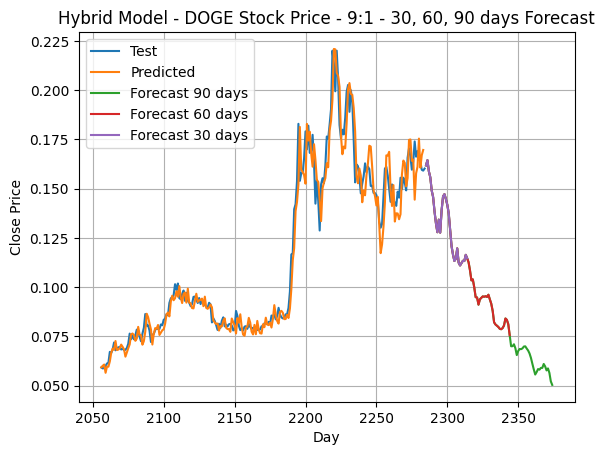

In [21]:
# Vẽ biểu đồ

# Vẽ dữ liệu kiểm tra
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Vẽ dự đoán cho dữ liệu kiểm tra (y_test_pred)
plt.plot(test_data_index[:-1], scaler.inverse_transform(y_test_pred.reshape(-1, 1)), label='Predicted')

# Vẽ dự báo 90, 60, 30 ngày
predict_data_index_90 = pd.RangeIndex(start=len(df1), stop=len(df1)+90, step=1)
plt.plot(predict_data_index_90, scaler.inverse_transform(np.array(forecast_90).reshape(-1, 1)), label='Forecast 90 days')

predict_data_index_60 = pd.RangeIndex(start=len(df1), stop=len(df1)+60, step=1)
plt.plot(predict_data_index_60, scaler.inverse_transform(np.array(forecast_60).reshape(-1, 1)), label='Forecast 60 days')

predict_data_index_30 = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(predict_data_index_30, scaler.inverse_transform(np.array(forecast_30).reshape(-1, 1)), label='Forecast 30 days')


plt.title('Hybrid Model - DOGE Stock Price - 9:1 - 30, 60, 90 days Forecast')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.grid()
plt.show